List of Project Phases

Data Preparation

Exploratory Data Analysis (EDA)

Feature Engineering

Model Building & Evaluation

Presentation and Handoff



## 📦 Data Preprocessing (Enhanced)

This step focuses on cleaning, normalizing, and enriching the movie dataset to prepare it for modeling and exploratory analysis. It builds upon a base preprocessing pipeline with added robustness and feature engineering.

### ✅ Steps Performed:

1. **Loading & Filtering**:
   - Loaded the first 1000 rows of the dataset.
   - Dropped rows where either `title` or `overview` is missing, as these are essential for text-based analysis.

2. **Text Normalization**:
   - Lowercased and stripped whitespace from key text columns: `title`, `overview`, `genre`, and `original_language`.
   - Removed duplicate movies based on title and overview.

3. **Datetime Processing**:
   - Converted `release_date` into datetime format.
   - Extracted `release_year` and `release_month`.
   - Created a `movie_age` feature (assumed current year = 2025).

4. **Numerical Feature Scaling**:
   - Used `MinMaxScaler` to normalize `popularity`, `vote_average`, and `vote_count`.
   - Engineered a new feature `vote_ratio = vote_average * log(1 + vote_count)` to capture both quality and quantity of votes.
   - Normalized `vote_ratio`.

5. **Genre Encoding**:
   - Split the comma-separated `genre` field into lists.
   - Used `MultiLabelBinarizer` to one-hot encode each unique genre into binary columns.

6. **Text Cleaning (Advanced)**:
   - Cleaned `overview` text further by removing punctuation, stopwords, and applying lemmatization using NLTK.
   - Resulting `overview_clean` is used for NLP tasks like similarity analysis.

7. **Final Steps**:
   - Reset the index after all transformations.
   - Saved the cleaned DataFrame to a CSV file (`dataset_preprocessed.csv`) for downstream tasks like EDA, modeling, and visualization.





In [ ]:
import pandas as pd
import numpy as np
import re
from sklearn.preprocessing import MinMaxScaler, MultiLabelBinarizer

# Load dataset
df = pd.read_csv('dataset.csv').head(1000)

# Drop rows where critical fields are missing
df.dropna(subset=['title', 'overview'], inplace=True)

# Clean text columns
text_cols = ['title', 'overview', 'genre', 'original_language']
for col in text_cols:
    df[col] = df[col].astype(str).str.lower().str.strip()

# Remove duplicates
df.drop_duplicates(subset=['title', 'overview'], inplace=True)

# Convert release_date to datetime
df['release_date'] = pd.to_datetime(df['release_date'], errors='coerce')
df['release_year'] = df['release_date'].dt.year
df['release_month'] = df['release_date'].dt.month
df['movie_age'] = 2025 - df['release_year']

# Normalize numeric features
scaler = MinMaxScaler()
df[['popularity_norm', 'vote_average_norm', 'vote_count_norm']] = scaler.fit_transform(
    df[['popularity', 'vote_average', 'vote_count']]
)

# Process genre field
df['genre_list'] = df['genre'].str.split(',')
mlb = MultiLabelBinarizer()
genre_dummies = pd.DataFrame(mlb.fit_transform(df['genre_list']), columns=mlb.classes_)
df = pd.concat([df, genre_dummies], axis=1)

# Clean overview text (remove punctuation, etc.)
def clean_text(text):
    text = re.sub(r"[^a-zA-Z0-9\s]", '', text)
    text = re.sub(r"\s+", ' ', text)
    return text.strip()

df['overview_clean'] = df['overview'].apply(clean_text)

# Reset index
df.reset_index(drop=True, inplace=True)

# Save cleaned dataset
df.to_csv('dataset_preprocessed.csv', index=False)

print("✅ Data preprocessing complete. Saved as 'dataset_preprocessed.csv'")


✅ Data preprocessing complete. Saved as 'dataset_preprocessed.csv'


## 📘 Phase 2: NLP Feature Enrichment (Enhanced)

In this phase, we enhance the movie dataset with additional features extracted from the cleaned movie overviews using NLP techniques:

### 🧠 1. Sentence-BERT Embeddings
We use the `all-MiniLM-L6-v2` model from Sentence-BERT to create 384-dimensional embeddings for each movie overview. These dense vectors capture semantic similarity and are useful for similarity analysis, clustering, and dimensionality reduction.

- **Tool**: `sentence-transformers`
- **Output**: Stored in a new column `sbert_embedding` as NumPy arrays.

### 😊 2. Sentiment Analysis with TextBlob
TextBlob is used to extract two sentiment scores from each overview:
- `sentiment_polarity`: Ranges from -1 (negative) to +1 (positive).
- `sentiment_subjectivity`: Ranges from 0 (objective) to 1 (subjective).

These scores can help assess the emotional tone of the movie descriptions.

### 🏷️ 3. Named Entity Recognition (NER) with spaCy
Using spaCy's `en_core_web_sm` model, we extract specific named entities from the overview:
- `persons`, `organizations`, `locations`, and `events`

We also compute the **count of each entity type** (`n_persons`, `n_organizations`, etc.), which can be used as numerical features.

### 📦 Output
The final enriched dataset is saved as:
``dataset_enriched.pkl`` — a pickle file that retains SBERT embeddings and all engineered features.

This enhanced dataset sets the stage for more insightful modeling and visualization in the next phases.


In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

import pandas as pd
from sentence_transformers import SentenceTransformer
from textblob import TextBlob
import spacy
from tqdm import tqdm
import numpy as np

# Load preprocessed dataset
df = pd.read_csv('dataset_preprocessed.csv').head(1000)

# Load models
sbert_model = SentenceTransformer('all-MiniLM-L6-v2')
nlp = spacy.load("en_core_web_sm")

# Ensure overview column is string
df['overview_clean'] = df['overview_clean'].astype(str)

# === SBERT Embedding ===
tqdm.pandas(desc="Encoding with SBERT")
df['sbert_embedding'] = df['overview_clean'].progress_apply(lambda x: sbert_model.encode(x))

# Convert SBERT list to numpy array for vector math later
df['sbert_embedding'] = df['sbert_embedding'].apply(lambda x: np.array(x))

# === Sentiment Analysis (TextBlob) ===
def get_sentiment(text):
    blob = TextBlob(text)
    return pd.Series({
        'sentiment_polarity': blob.sentiment.polarity,
        'sentiment_subjectivity': blob.sentiment.subjectivity
    })

df[['sentiment_polarity', 'sentiment_subjectivity']] = df['overview_clean'].apply(get_sentiment)

# === Named Entity Extraction (spaCy) ===
def extract_entities(text):
    doc = nlp(text)
    return {
        'persons': [ent.text for ent in doc.ents if ent.label_ == 'PERSON'],
        'organizations': [ent.text for ent in doc.ents if ent.label_ == 'ORG'],
        'locations': [ent.text for ent in doc.ents if ent.label_ == 'GPE'],
        'events': [ent.text for ent in doc.ents if ent.label_ == 'EVENT']
    }

tqdm.pandas(desc="Extracting named entities")
entity_df = df['overview_clean'].progress_apply(extract_entities).apply(pd.Series)
df = pd.concat([df, entity_df], axis=1)

# === Named Entity Features ===
df['n_persons'] = df['persons'].apply(len)
df['n_organizations'] = df['organizations'].apply(len)
df['n_locations'] = df['locations'].apply(len)
df['n_events'] = df['events'].apply(len)

# Save enriched dataset
df.to_pickle('dataset_enriched.pkl')  # Pickle to preserve SBERT vectors
print("✅ Enriched dataset saved as 'dataset_enriched.pkl'")



Extracting named entities: 100%|██████████| 1000/1000 [00:17<00:00, 57.46it/s]


✅ Enriched dataset saved as 'dataset_enriched.pkl'


# 📊 Visualization Summary for Enriched Movie Dataset

This notebook visualizes key aspects of the enriched movie dataset to help us better understand the semantic, emotional, and entity-level properties of the films.

---

## 1. 🎯 t-SNE Visualization of SBERT Embeddings

- **What it shows:**  
  A 2D scatter plot generated using t-SNE on high-dimensional Sentence-BERT (SBERT) embeddings of movie overviews.

- **Purpose:**  
  Helps visualize semantic similarities between movies. Movies with similar themes or content will be closer in the 2D space.

- **Tool used:**  
  `sklearn.manifold.TSNE`

---

## 2. ❤️ Sentiment Polarity vs Subjectivity

- **What it shows:**  
  A scatter plot of sentiment polarity (negative to positive) vs. subjectivity (objective to subjective) for each movie overview.

- **Purpose:**  
  Helps identify the emotional tone and degree of subjectivity in movie plots.

- **Hue (optional):**  
  If `mood_composite` labels are present, they are used to color the points for deeper analysis.

---

## 3. 🧠 Named Entity Word Cloud

- **What it shows:**  
  A word cloud built from all named entities (Persons, Organizations, Locations, Events) extracted from movie overviews using spaCy.

- **Purpose:**  
  Highlights commonly mentioned real-world entities or concepts in the dataset, giving a quick glance at prevalent narrative elements.

- **Tool used:**  
  `WordCloud` from the `wordcloud` library


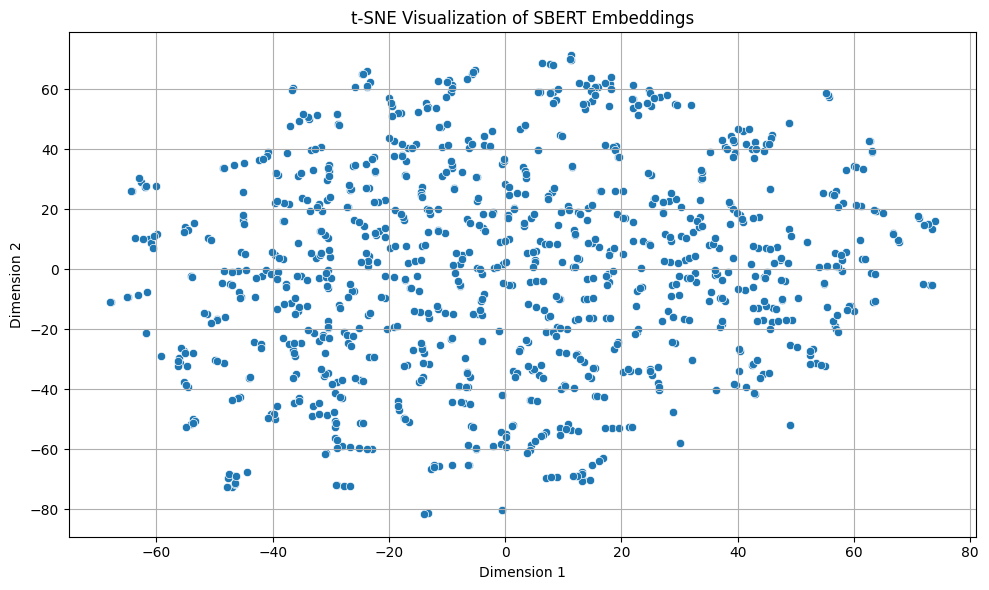

<ipython-input-49-e3879eae84c0>:28: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(


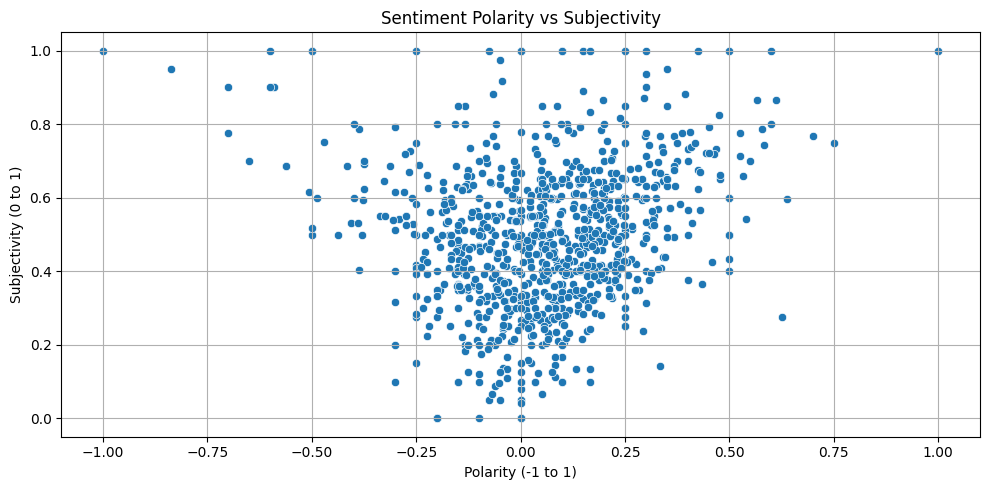

<ipython-input-49-e3879eae84c0>:44: FutureWarning: The provided callable <built-in function sum> is currently using DataFrame.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  df['combined_entities'] = df[['persons', 'organizations', 'locations', 'events']].agg(sum, axis=1)


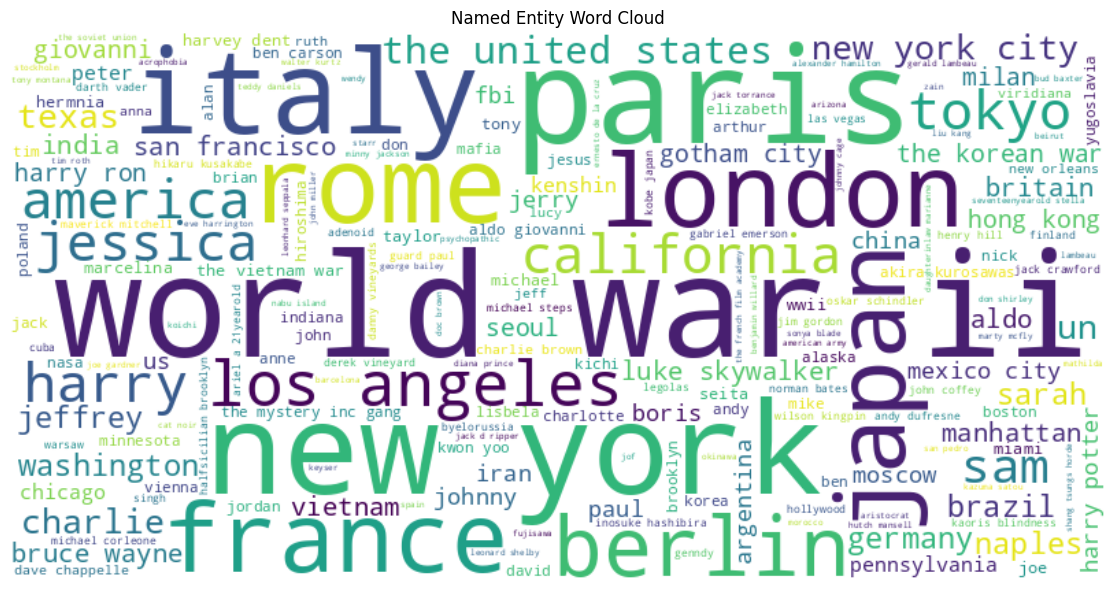

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from wordcloud import WordCloud
from collections import Counter

# Load enriched data
df = pd.read_pickle('dataset_enriched.pkl')

# === 1. SBERT Embedding Visualization ===
X = np.vstack(df['sbert_embedding'].values)
tsne = TSNE(n_components=2, perplexity=5, random_state=42)
X_2d = tsne.fit_transform(X)

plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_2d[:, 0], y=X_2d[:, 1])
plt.title("t-SNE Visualization of SBERT Embeddings")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.grid(True)
plt.tight_layout()
plt.show()

# === 2. Sentiment Distribution ===
plt.figure(figsize=(10, 5))
sns.scatterplot(
    x=df['sentiment_polarity'],
    y=df['sentiment_subjectivity'],
    hue=df['mood_composite'] if 'mood_composite' in df.columns else None,
    palette="coolwarm",
    edgecolor="w"
)
plt.title("Sentiment Polarity vs Subjectivity")
plt.xlabel("Polarity (-1 to 1)")
plt.ylabel("Subjectivity (0 to 1)")
plt.grid(True)
plt.tight_layout()
plt.show()

# === 3. Named Entity Word Cloud ===
# Combine all entity columns
df['combined_entities'] = df[['persons', 'organizations', 'locations', 'events']].agg(sum, axis=1)
all_entities = sum(df['combined_entities'], [])
entity_freq = dict(Counter(all_entities))

wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(entity_freq)

plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Named Entity Word Cloud")
plt.tight_layout()
plt.show()


## 📊 Enhanced Exploratory Data Analysis (EDA)

This section explores key insights from the enriched movie dataset, using visualizations and statistical summaries to understand patterns in genres, sentiment, release trends, and named entities.

### 1. Dataset Overview
We begin with a quick look at the dataset shape, missing values, and duplicate entries to ensure data quality before analysis.

### 2. Numeric Feature Distributions
Histograms display the spread of features like popularity, average rating, and sentiment scores. This helps identify skewness and detect any outliers.

### 3. Movie Releases Over Time
A histogram of movie release years reveals production trends across decades—such as industry booms or lulls.

### 4. Genre Distribution
A bar chart shows the frequency of each movie genre. This helps identify which types of films dominate the dataset (e.g., drama, comedy, thriller).

### 5. Genre Co-occurrence Heatmap
This heatmap illustrates how often genres appear together in movies, revealing common combinations like action + adventure or romance + drama.

### 6. Sentiment by Genre
Boxplots display sentiment polarity (positive vs negative) by genre, helping us understand which genres tend to have more optimistic or pessimistic tones.

### 7. Language Distribution
This bar plot highlights the top 10 original languages of the films, giving insight into linguistic diversity and dominant film industries.

### 8. Named Entity Word Clouds
Word clouds for persons, organizations, locations, and events visualize the most frequently mentioned named entities in movie overviews, offering a glimpse into recurring characters, places, and narrative themes.

---

Each of these insights supports deeper understanding and modeling of user mood and movie content in subsequent recommendation phases.


Shape: (1000, 46)

Missing Values:
 id                        0
title                     0
genre                     0
original_language         0
overview                  0
popularity                0
release_date              0
vote_average              0
vote_count                0
release_year              0
release_month             0
movie_age                 0
popularity_norm           0
vote_average_norm         0
vote_count_norm           0
genre_list                0
action                    0
adventure                 0
animation                 0
comedy                    0
crime                     0
drama                     0
family                    0
fantasy                   0
history                   0
horror                    0
music                     0
mystery                   0
romance                   0
science fiction           0
thriller                  0
tv movie                  0
war                       0
western                   0
overview_cle

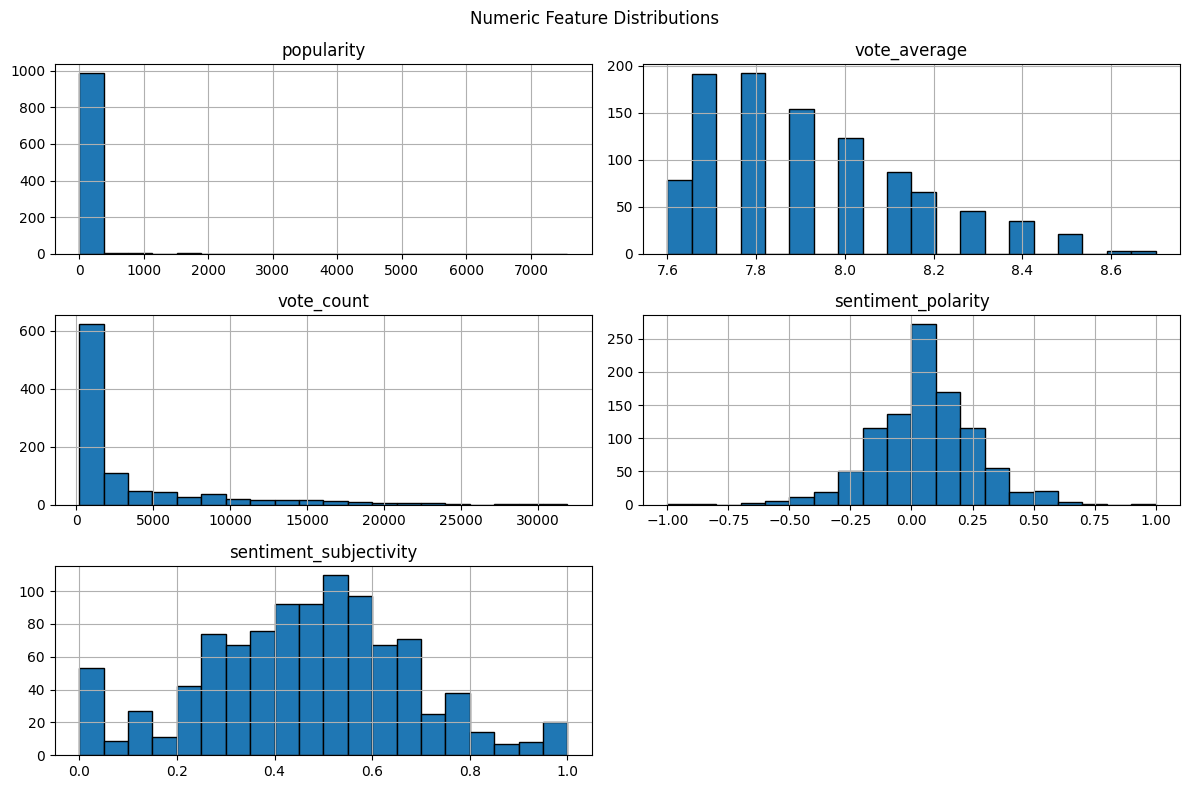

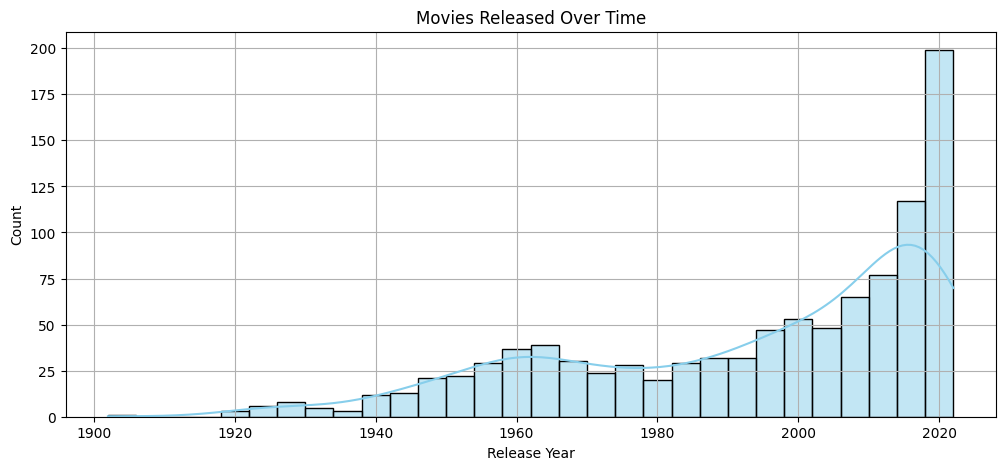

<ipython-input-50-d488f7bfa99c>:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=genre_counts.index, y=genre_counts.values, palette="Set2")


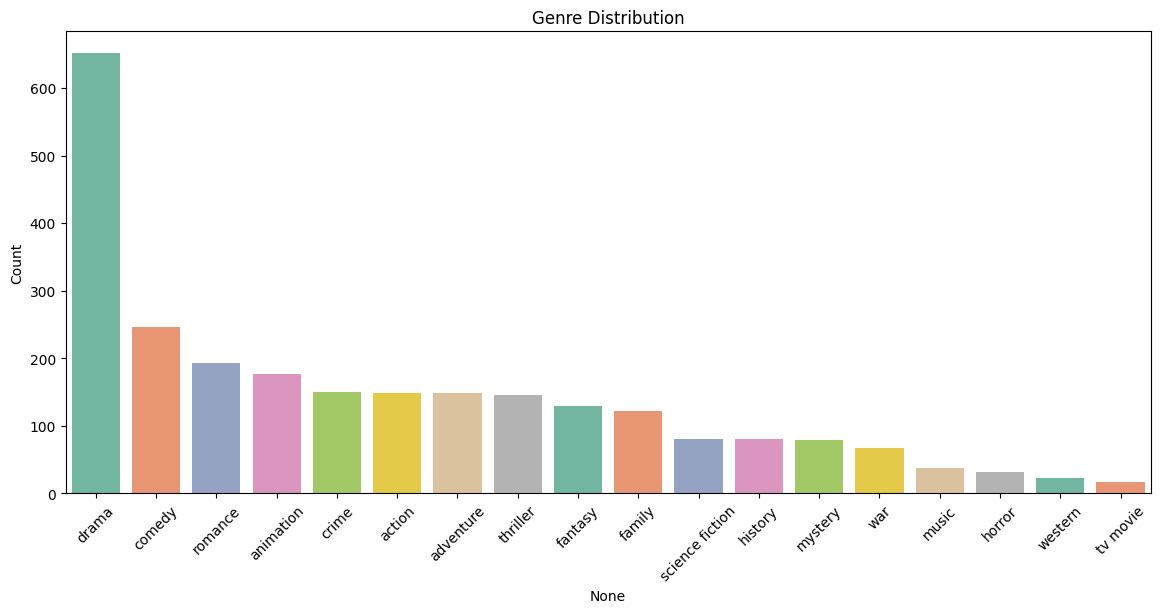

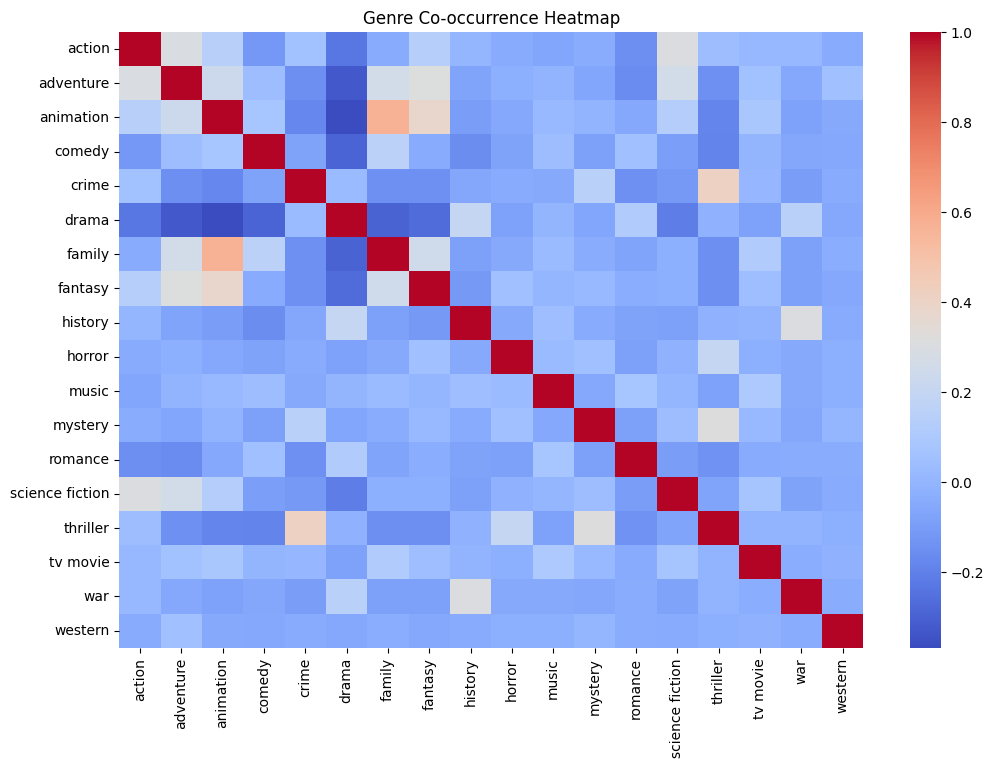

<ipython-input-50-d488f7bfa99c>:54: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='genre', y='sentiment_polarity', data=df_melt[df_melt['has_genre'] == 1], palette='pastel')


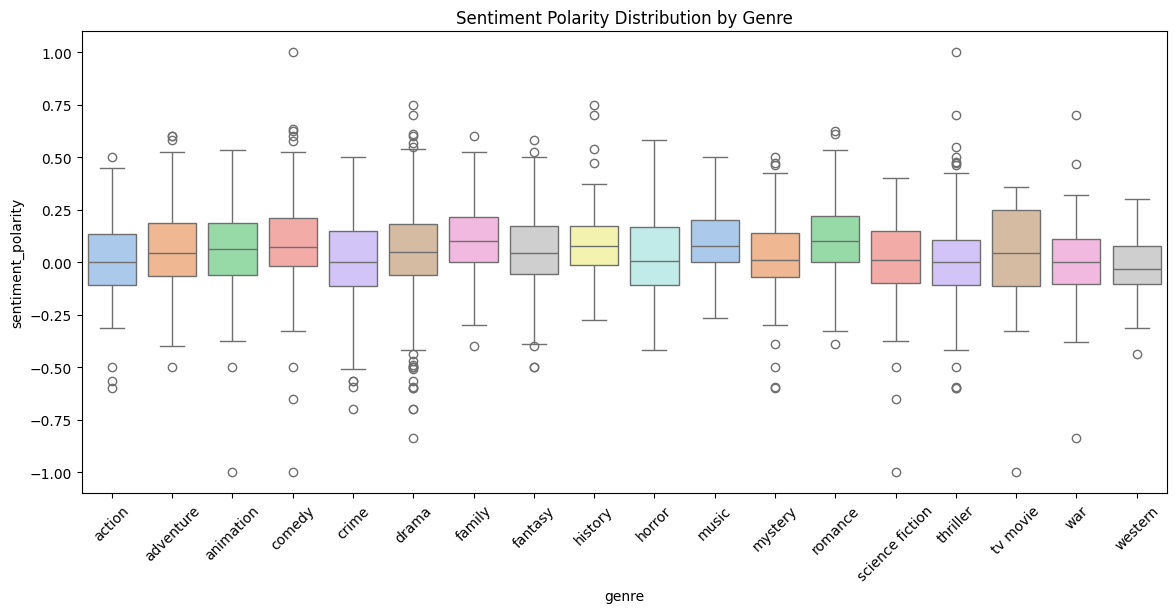

<ipython-input-50-d488f7bfa99c>:62: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=lang_counts.index, y=lang_counts.values, palette='viridis')


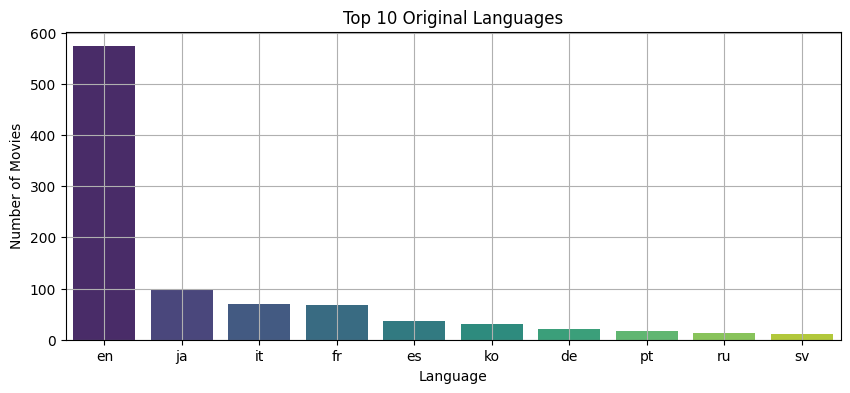

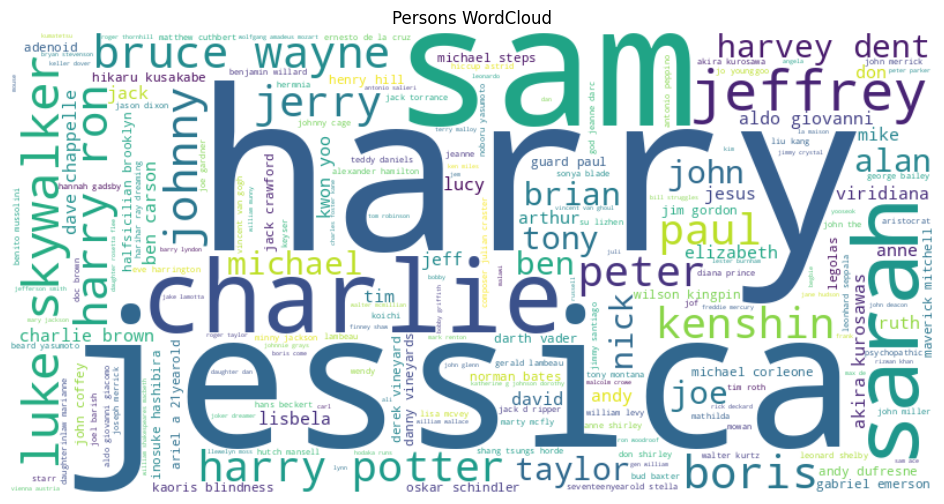

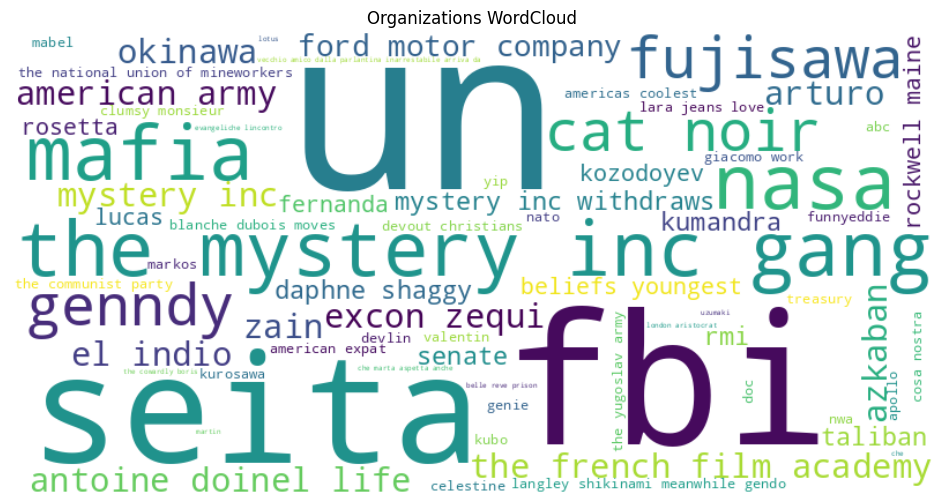

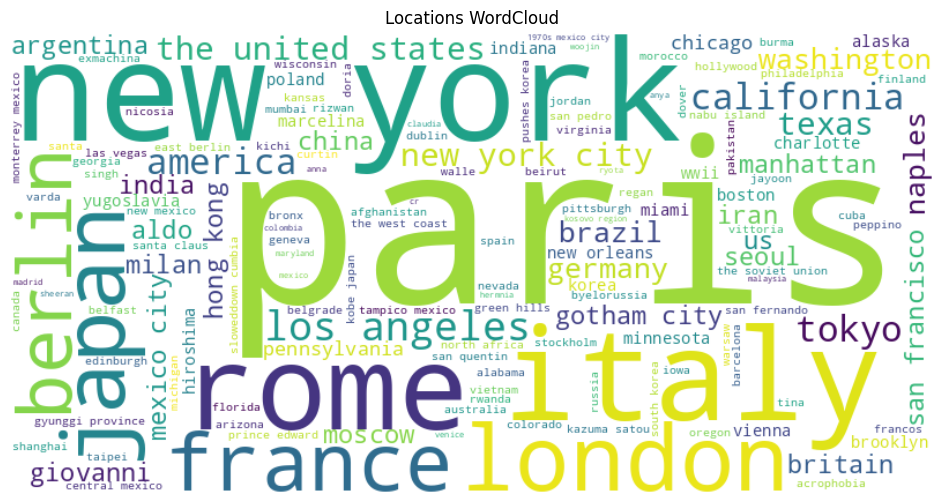

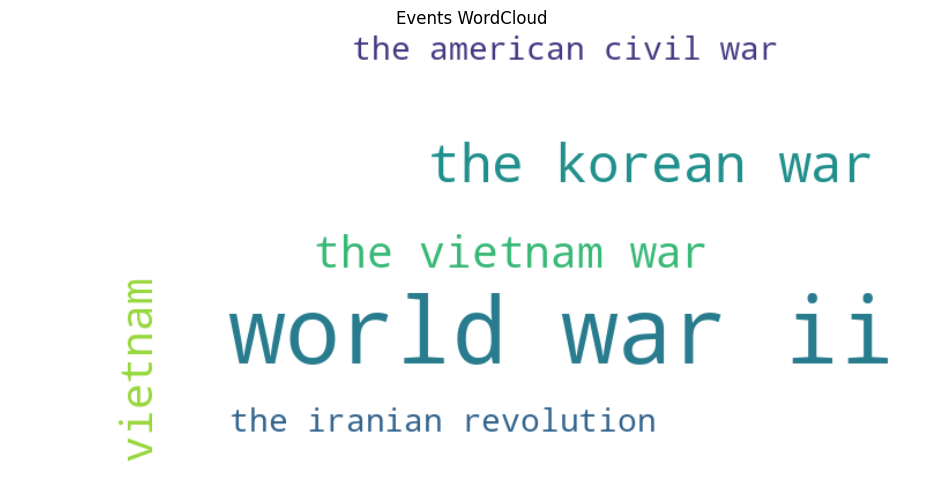

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from collections import Counter

# Load enriched data
df = pd.read_pickle('dataset_enriched.pkl')

# === 1. Dataset Overview ===
print("Shape:", df.shape)
print("\nMissing Values:\n", df.isnull().sum())
print("\nDuplicates:", df.duplicated(subset=['title', 'overview']).sum())

# === 2. Numeric Feature Distributions ===
num_cols = ['popularity', 'vote_average', 'vote_count', 'sentiment_polarity', 'sentiment_subjectivity']
df[num_cols].hist(figsize=(12, 8), bins=20, edgecolor='black')
plt.suptitle("Numeric Feature Distributions")
plt.tight_layout()
plt.show()

# === 3. Movie Releases Over Time ===
plt.figure(figsize=(12, 5))
sns.histplot(df['release_year'].dropna(), bins=30, kde=True, color='skyblue')
plt.title("Movies Released Over Time")
plt.xlabel("Release Year")
plt.ylabel("Count")
plt.grid(True)
plt.show()

# === 4. Genre Distribution ===
genre_cols = ['action', 'adventure', 'animation', 'comedy', 'crime', 'drama', 'family', 'fantasy',
              'history', 'horror', 'music', 'mystery', 'romance', 'science fiction', 'thriller',
              'tv movie', 'war', 'western']
genre_counts = df[genre_cols].sum().sort_values(ascending=False)

plt.figure(figsize=(14, 6))
sns.barplot(x=genre_counts.index, y=genre_counts.values, palette="Set2")
plt.title("Genre Distribution")
plt.xticks(rotation=45)
plt.ylabel("Count")
plt.show()

# === 5. Genre Co-occurrence Heatmap ===
genre_corr = df[genre_cols].corr()
plt.figure(figsize=(12, 8))
sns.heatmap(genre_corr, annot=False, cmap='coolwarm', fmt=".2f")
plt.title("Genre Co-occurrence Heatmap")
plt.show()

# === 6. Sentiment by Genre (Boxplot) ===
plt.figure(figsize=(14, 6))
df_melt = df.melt(id_vars=['sentiment_polarity'], value_vars=genre_cols, var_name='genre', value_name='has_genre')
sns.boxplot(x='genre', y='sentiment_polarity', data=df_melt[df_melt['has_genre'] == 1], palette='pastel')
plt.title("Sentiment Polarity Distribution by Genre")
plt.xticks(rotation=45)
plt.show()

# === 7. Language Distribution ===
plt.figure(figsize=(10, 4))
lang_counts = df['original_language'].value_counts().head(10)
sns.barplot(x=lang_counts.index, y=lang_counts.values, palette='viridis')
plt.title("Top 10 Original Languages")
plt.ylabel("Number of Movies")
plt.xlabel("Language")
plt.grid(True)
plt.show()

# === 8. Named Entity Frequency WordClouds ===
for entity_type in ['persons', 'organizations', 'locations', 'events']:
    all_ents = sum(df[entity_type], [])
    ent_freq = dict(Counter(all_ents))
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(ent_freq)

    plt.figure(figsize=(12, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"{entity_type.capitalize()} WordCloud")
    plt.show()

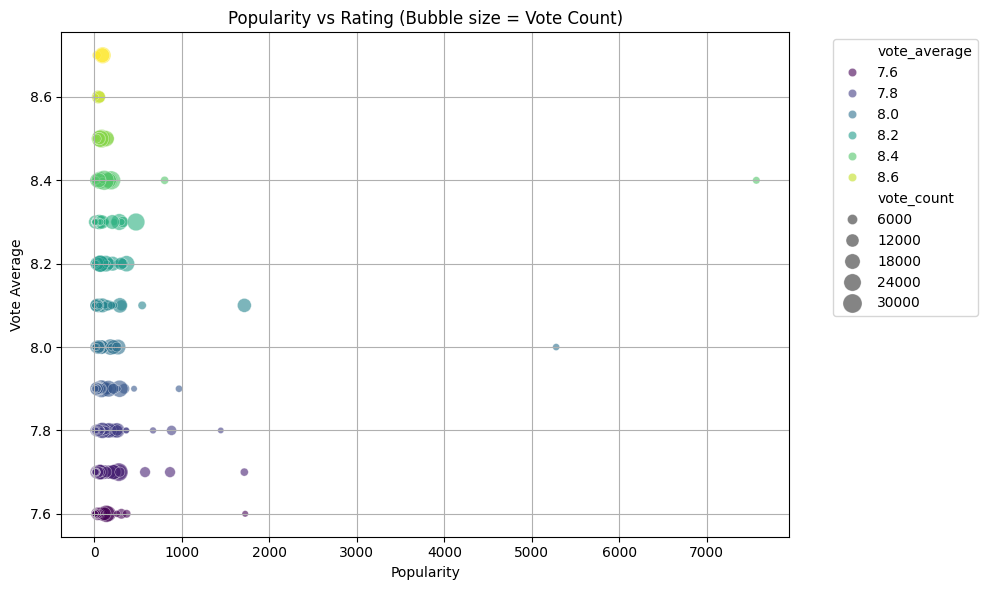

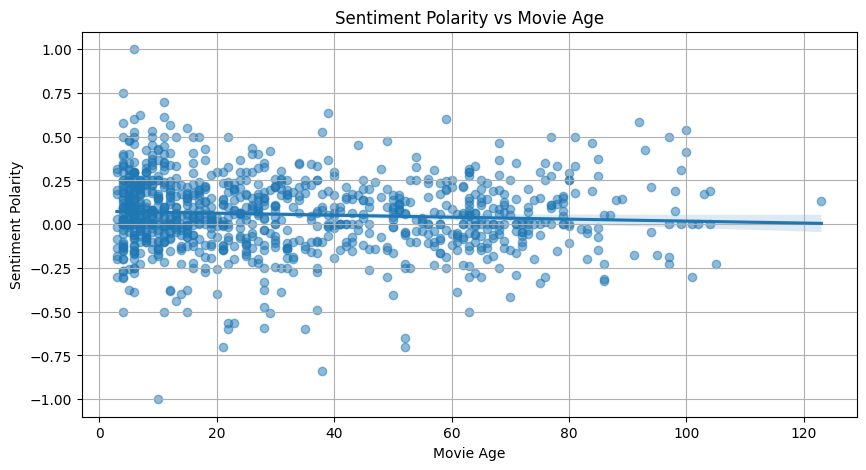

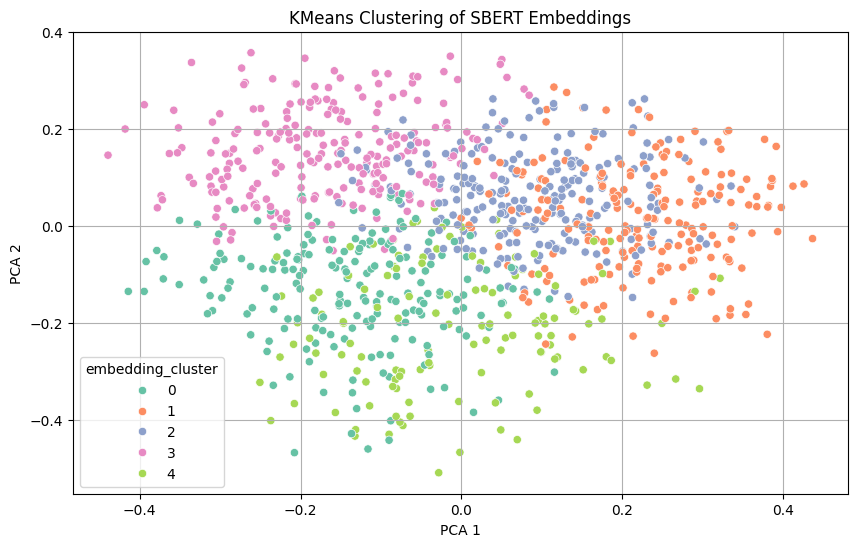

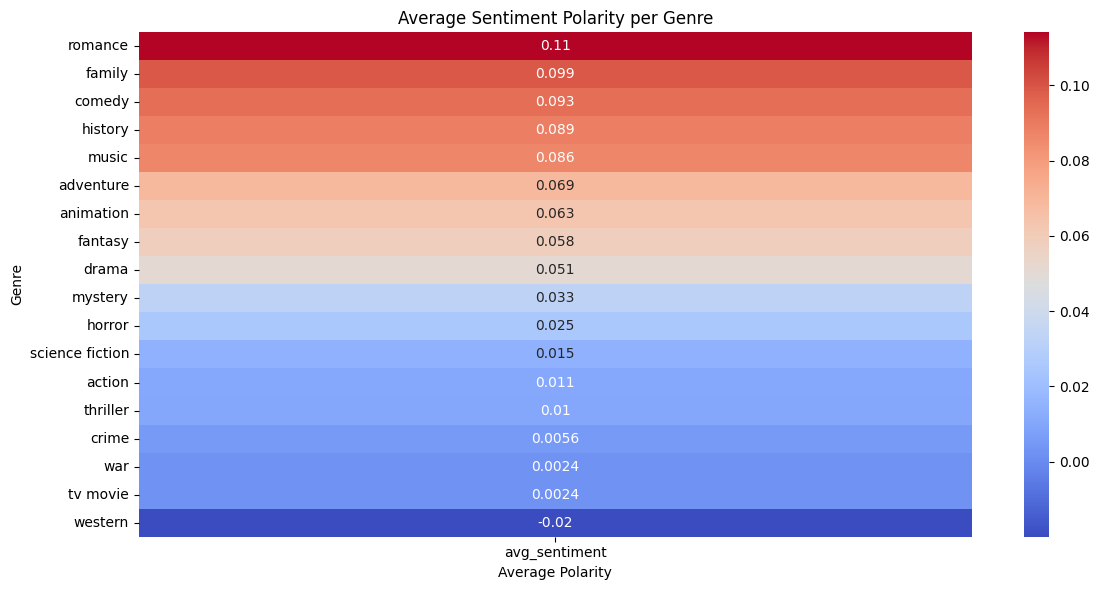

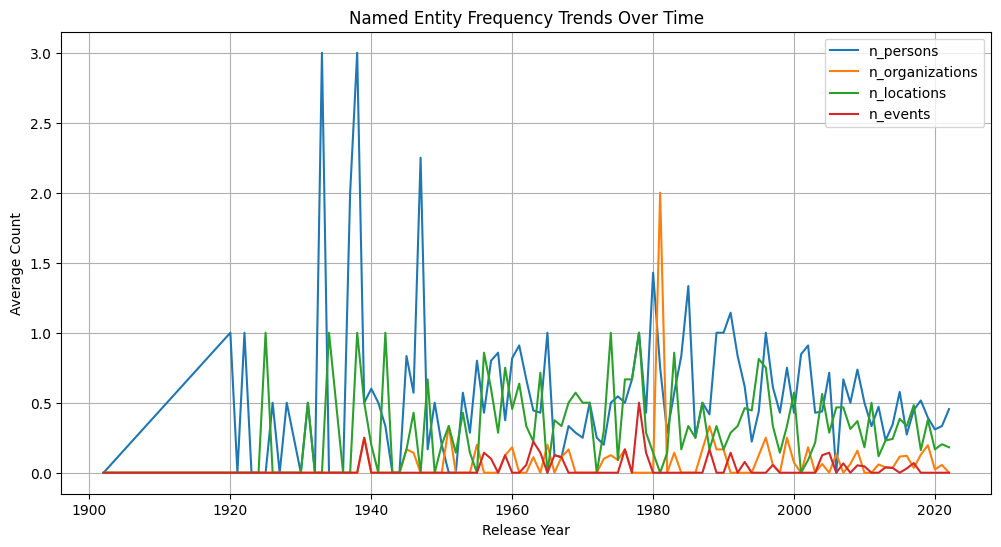

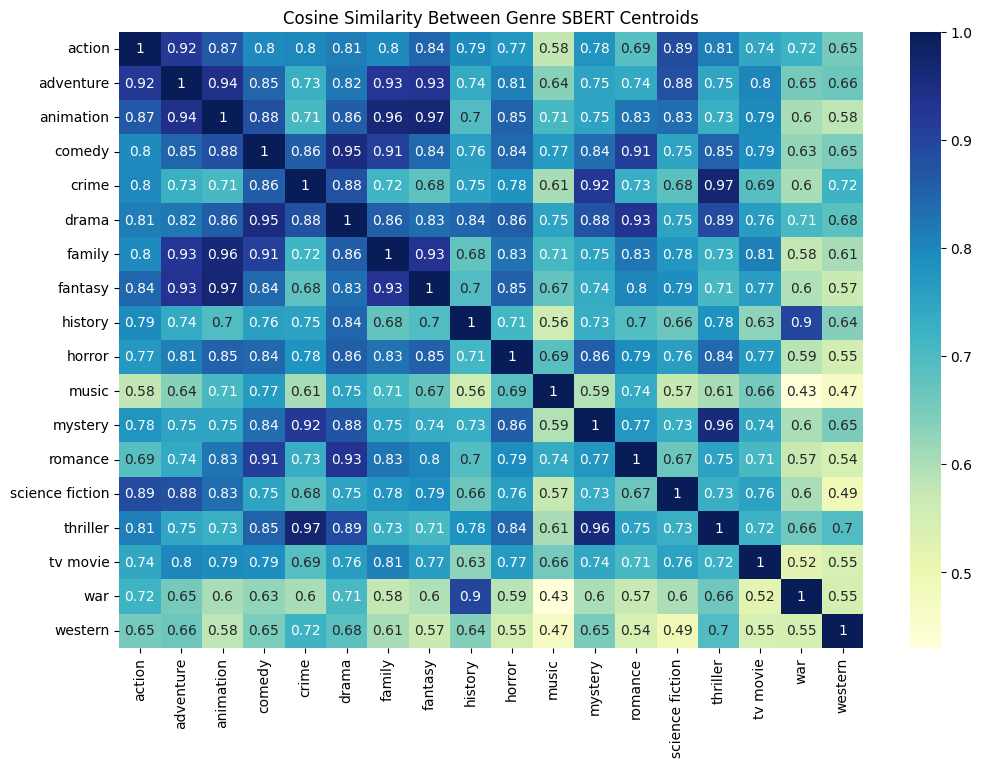

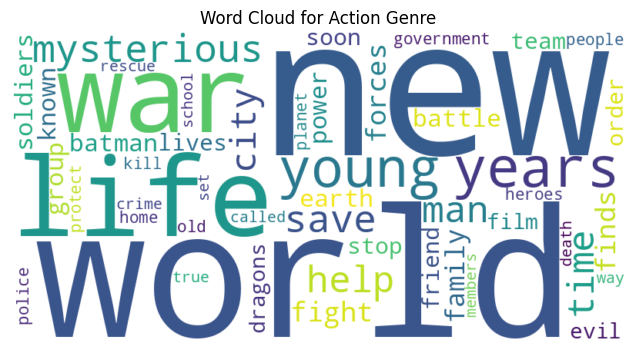

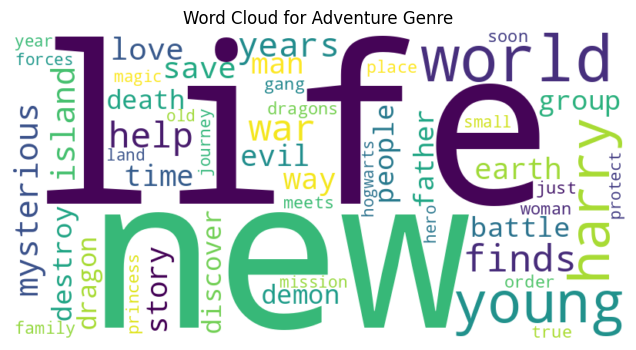

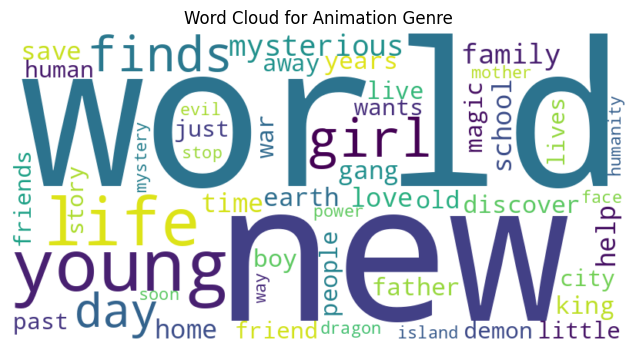

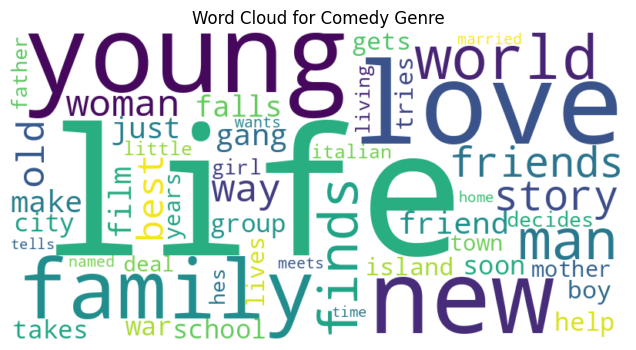

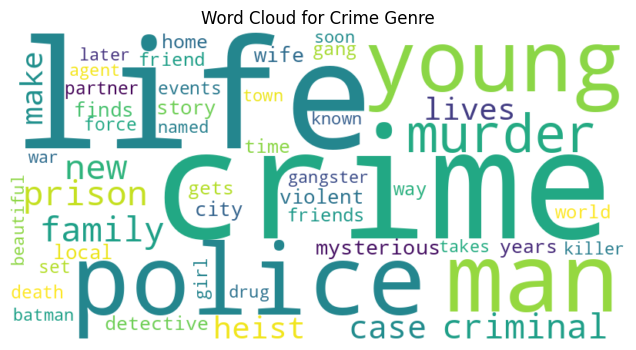

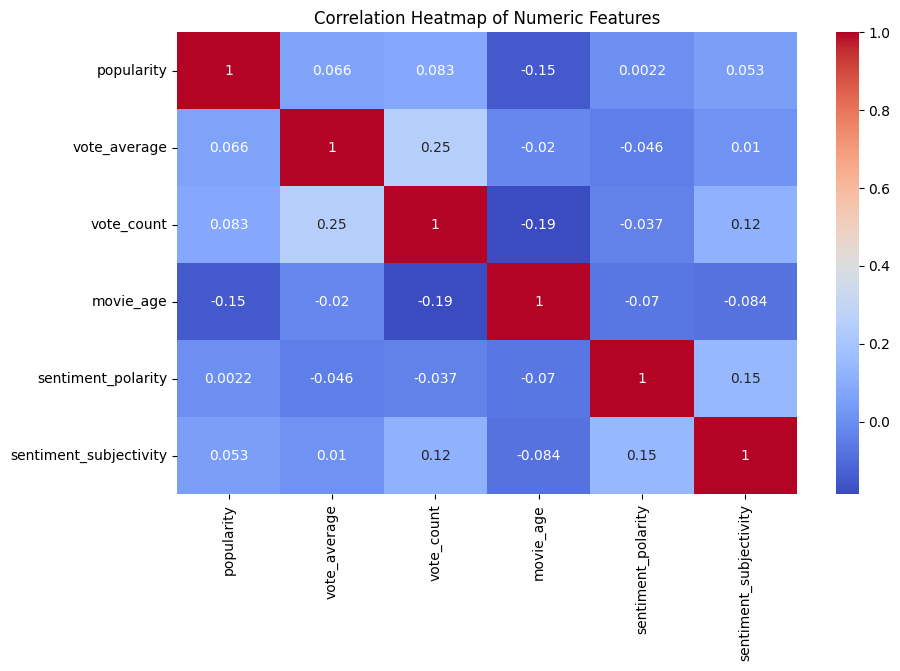

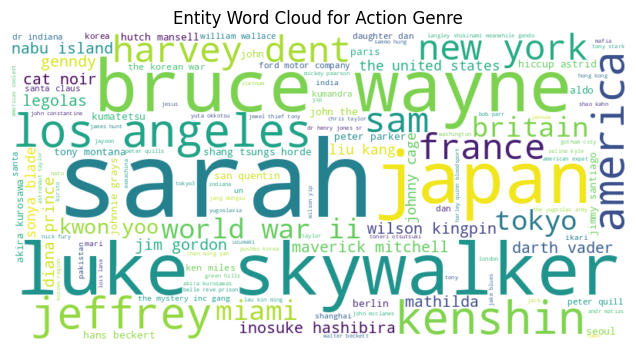

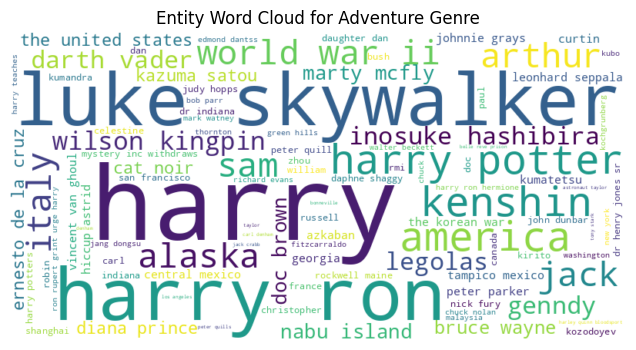

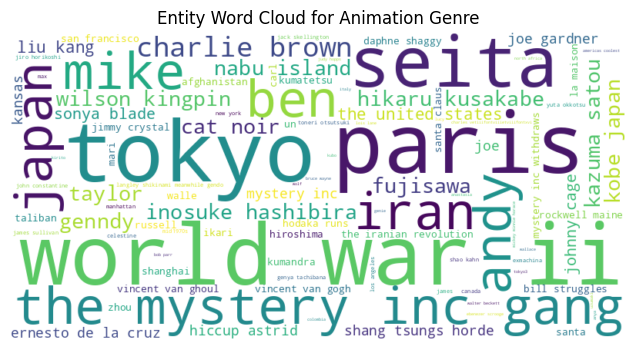

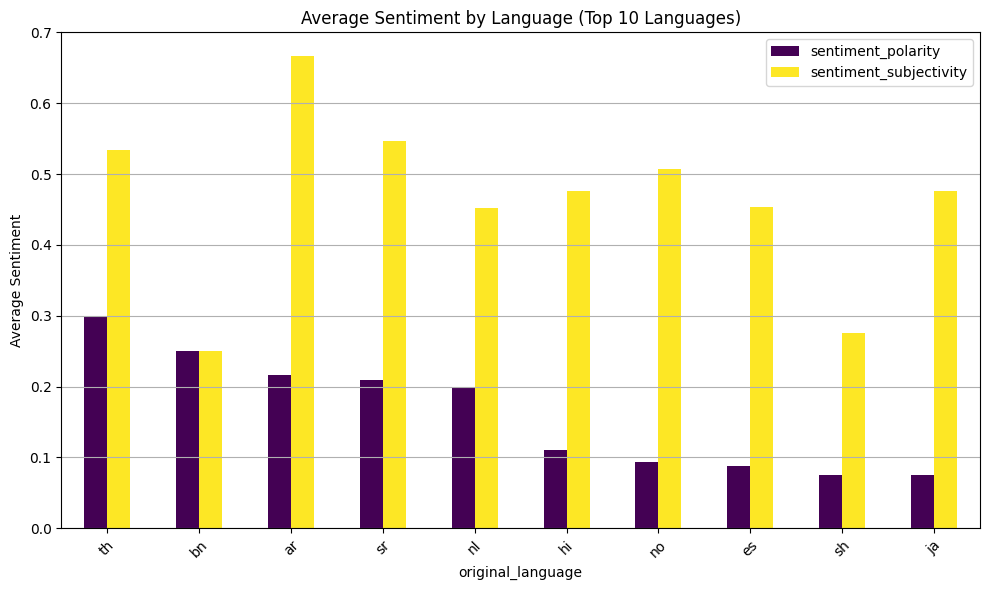

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity
from wordcloud import WordCloud
from collections import Counter
from sklearn.preprocessing import StandardScaler

# Load enriched dataset
df = pd.read_pickle('dataset_enriched.pkl')

# === 1. Popularity vs Rating Bubble Plot ===
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='popularity', y='vote_average', size='vote_count', hue='vote_average', sizes=(20, 200), alpha=0.6, palette='viridis')
plt.title("Popularity vs Rating (Bubble size = Vote Count)")
plt.xlabel("Popularity")
plt.ylabel("Vote Average")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

# === 2. Sentiment vs Movie Age ===
plt.figure(figsize=(10, 5))
sns.regplot(x='movie_age', y='sentiment_polarity', data=df, scatter_kws={'alpha':0.5})
plt.title("Sentiment Polarity vs Movie Age")
plt.xlabel("Movie Age")
plt.ylabel("Sentiment Polarity")
plt.grid(True)
plt.show()

# === 3. SBERT Embedding Clustering (KMeans) ===
X = np.vstack(df['sbert_embedding'].values)
kmeans = KMeans(n_clusters=5, random_state=42)
df['embedding_cluster'] = kmeans.fit_predict(X)

pca = PCA(n_components=2)
X_2d = pca.fit_transform(X)

plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_2d[:, 0], y=X_2d[:, 1], hue=df['embedding_cluster'], palette='Set2')
plt.title("KMeans Clustering of SBERT Embeddings")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.grid(True)
plt.show()

# === 4. Genre vs Sentiment Heatmap ===
# Select genre columns (update indices if your dataset structure changes)
genre_cols = ['action', 'adventure', 'animation', 'comedy', 'crime', 'drama',
              'family', 'fantasy', 'history', 'horror', 'music', 'mystery',
              'romance', 'science fiction', 'thriller', 'tv movie', 'war', 'western']

# Compute average sentiment polarity for each genre
genre_sentiment = {}
for genre in genre_cols:
    mask = df[genre] == 1
    genre_sentiment[genre] = df.loc[mask, 'sentiment_polarity'].mean()

# Convert to DataFrame for heatmap
genre_sentiment_df = pd.DataFrame.from_dict(genre_sentiment, orient='index', columns=['avg_sentiment'])

# Plot heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(genre_sentiment_df.sort_values('avg_sentiment', ascending=False), annot=True, cmap='coolwarm')
plt.title("Average Sentiment Polarity per Genre")
plt.ylabel("Genre")
plt.xlabel("Average Polarity")
plt.tight_layout()
plt.show()

# === 5. Entity Category Trends Over Time ===
entity_cols = ['n_persons', 'n_organizations', 'n_locations', 'n_events']
df_yearly = df.groupby('release_year')[entity_cols].mean().dropna()

plt.figure(figsize=(12, 6))
for col in entity_cols:
    plt.plot(df_yearly.index, df_yearly[col], label=col)
plt.title("Named Entity Frequency Trends Over Time")
plt.xlabel("Release Year")
plt.ylabel("Average Count")
plt.legend()
plt.grid(True)
plt.show()

# === 6. Genre-wise SBERT Centroid Similarity ===
genre_centroids = {}
for genre in genre_cols:
    vectors = np.vstack(df[df[genre] == 1]['sbert_embedding'].values)
    genre_centroids[genre] = np.mean(vectors, axis=0)

similarity_matrix = cosine_similarity(list(genre_centroids.values()))

plt.figure(figsize=(12, 8))
sns.heatmap(similarity_matrix, xticklabels=genre_centroids.keys(), yticklabels=genre_centroids.keys(), cmap='YlGnBu', annot=True)
plt.title("Cosine Similarity Between Genre SBERT Centroids")
plt.show()

# === 7. Word Frequency by Genre (TF-IDF Not Applied Here, Use Simple Count) ===
import re
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(stop_words='english', max_features=50)
for genre in genre_cols[:5]:  # Limit for visualization
    subset = df[df[genre] == 1]['overview_clean']
    word_matrix = cv.fit_transform(subset)
    freqs = dict(zip(cv.get_feature_names_out(), word_matrix.sum(axis=0).A1))
    wc = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(freqs)
    plt.figure(figsize=(10, 4))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"Word Cloud for {genre.title()} Genre")
    plt.show()

# === 8. Correlation Heatmap for Numeric Features ===
numeric_cols = ['popularity', 'vote_average', 'vote_count', 'movie_age', 'sentiment_polarity', 'sentiment_subjectivity']
plt.figure(figsize=(10, 6))
sns.heatmap(df[numeric_cols].corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap of Numeric Features")
plt.show()

# === 9. Entity Cloud by Genre ===
for genre in genre_cols[:3]:  # Limit for visualization
    entities = df[df[genre] == 1][['persons', 'organizations', 'locations', 'events']].values.flatten().tolist()
    all_words = [e for lst in entities if isinstance(lst, list) for e in lst]
    if all_words:
        freq = dict(Counter(all_words))
        wc = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(freq)
        plt.figure(figsize=(10, 4))
        plt.imshow(wc, interpolation='bilinear')
        plt.axis('off')
        plt.title(f"Entity Word Cloud for {genre.title()} Genre")
        plt.show()

# === 10. Language-wise Sentiment Averages ===
language_sentiments = df.groupby('original_language')[['sentiment_polarity', 'sentiment_subjectivity']].mean().sort_values(by='sentiment_polarity', ascending=False).head(10)

language_sentiments.plot(kind='bar', figsize=(10, 6), colormap='viridis')
plt.title("Average Sentiment by Language (Top 10 Languages)")
plt.ylabel("Average Sentiment")
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

## 🔍 Feature Engineering and Dimensionality Reduction (PCA)

This step enhances the enriched dataset by generating meaningful features and reducing the high-dimensional SBERT embeddings for easier visualization and modeling.

### 🛠 Feature Engineering

Several new features were extracted from existing data:

- **Overview Length**: Measures the length of each movie overview in characters.
- **Entity Counts**: Counts the number of extracted named entities per category:
  - `n_persons`: Number of named people.
  - `n_organizations`: Number of organizations.
  - `n_locations`: Number of locations.
  - `n_events`: Number of events.
- **Sentiment Interactions**: Includes interaction terms like:
  - `polarity_subjectivity`: Product of sentiment polarity and subjectivity.
  - `polarity_squared`: Square of the sentiment polarity, capturing non-linearity.
- **Genre Richness**: Total number of genres a movie belongs to.

These engineered features help reveal hidden patterns that might improve downstream ML performance.

### 🧬 Dimensionality Reduction with PCA

- **Input**: High-dimensional SBERT embeddings (`384` dimensions).
- **Process**: Principal Component Analysis (PCA) is used to reduce embeddings to:
  - `pca_2d_x`, `pca_2d_y`: For 2D visualization.
  - `pca_50d_0` to `pca_50d_49`: A compressed 50-dimensional representation suitable for modeling.

### 💾 Output

- All new features and PCA projections are saved to a new file: `dataset_enriched_features.pkl`.
- This file can now be used for clustering, visualization, and training machine learning models efficiently.

```python
pd.read_pickle('dataset_enriched_features.pkl').head()
```

Use the code above to load and inspect the enriched and transformed dataset.


## 🎬 Mood-Based Enrichment of Movie Dataset using SBERT and Sentiment

This notebook performs **automatic mood assignment** for movies using a combination of **semantic embeddings (SBERT)** and **sentiment analysis**. Here's a breakdown of the steps:

---

### 📦 1. Dataset Loading and Preparation
- The enriched dataset (`dataset_enriched.pkl`) is loaded.
- `SentenceTransformer` with the `'all-MiniLM-L6-v2'` model is used to compute semantic representations of text.

---

### 😊 2. Definition of Basic Moods
- 10 **basic moods** (e.g., Happy, Sad, Angry, etc.) are defined along with short, descriptive sentences that capture the essence of each mood.
- These descriptions are then encoded using SBERT to create a **mood embedding matrix**.

---

### 🧠 3. Similarity and Sentiment-Based Adjustment
- For each movie:
  - Its existing `sbert_embedding` (derived from overview/description) is compared with each mood description via **cosine similarity**.
  - The similarity scores are then **adjusted based on sentiment polarity**:
    - High positive sentiment boosts "Happy" and "Excited".
    - Strong negative sentiment boosts "Sad", "Angry", and "Fearful".
    - Neutral sentiment slightly boosts "Calm" and "Bored".

---

### 🎭 4. Composite Mood Assignment
- The **top 3 most similar moods** (after adjustment) are assigned to each movie under the column `mood_composite`.
- A human-readable version (`mood_composite_str`) joins the list into a comma-separated string.

---

### 💾 5. Save Mood-Tagged Dataset
- The updated dataset is saved as `dataset_mood_adjusted.pkl`.

---

### 📊 6. Visualization: Mood Distribution
- A **bar chart** is plotted using Seaborn to show the frequency of each assigned mood across the dataset.

---

This approach allows for **automated, multi-dimensional mood tagging** using both textual semantics and emotional tone, which is useful for mood-based movie recommendation systems.


Assigning mood with sentiment: 100%|██████████| 1000/1000 [00:00<00:00, 1629.39it/s]
<ipython-input-52-af92d0956508>:69: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(mood_freq.keys()), y=list(mood_freq.values()), palette='pastel')


✅ Mood-adjusted dataset saved as 'dataset_mood_adjusted.pkl'


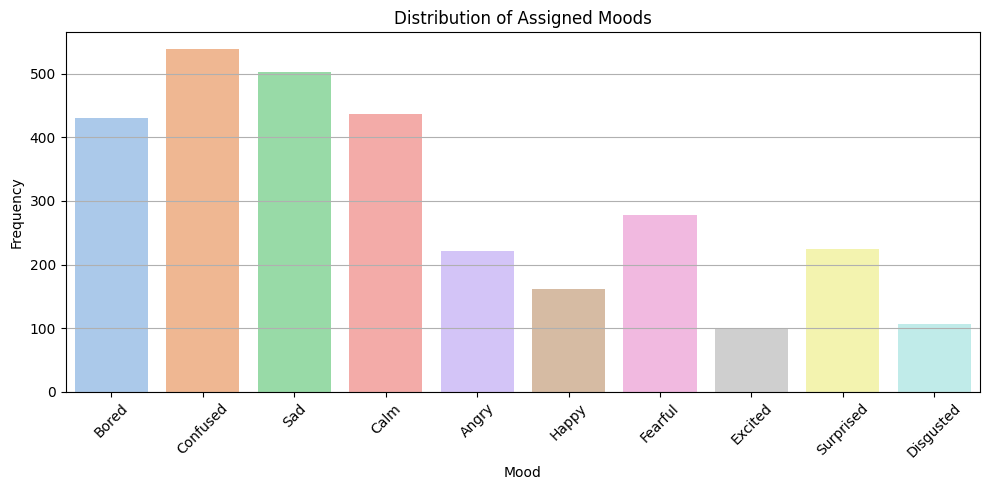

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from sentence_transformers import SentenceTransformer
from tqdm import tqdm

# Load dataset
df = pd.read_pickle('dataset_enriched.pkl')
sbert_model = SentenceTransformer('all-MiniLM-L6-v2')

# Define basic moods with descriptions
moods = {
    "Happy": "This movie is cheerful, joyful and uplifting.",
    "Sad": "This movie is tragic, emotional and melancholic.",
    "Angry": "This movie is intense, aggressive and filled with rage.",
    "Fearful": "This movie is scary, tense and induces fear.",
    "Disgusted": "This movie is disturbing, gross and revolting.",
    "Surprised": "This movie is unexpected, shocking and full of twists.",
    "Calm": "This movie is peaceful, serene and relaxing.",
    "Excited": "This movie is thrilling, fast-paced and adrenaline-pumping.",
    "Bored": "This movie is dull, monotonous and slow-paced.",
    "Confused": "This movie is confusing, complex and difficult to understand."
}

# Encode mood phrases
mood_labels = list(moods.keys())
mood_matrix = np.vstack([sbert_model.encode(moods[m]) for m in mood_labels])

# Adjust scores based on sentiment
def adjust_with_sentiment(similarities, polarity):
    boost = similarities.copy()
    if polarity > 0.5:
        boost[mood_labels.index("Happy")] += 0.1
        boost[mood_labels.index("Excited")] += 0.1
    elif polarity < -0.5:
        for mood in ["Sad", "Angry", "Fearful"]:
            boost[mood_labels.index(mood)] += 0.1
    else:
        boost[mood_labels.index("Calm")] += 0.05
        boost[mood_labels.index("Bored")] += 0.05
    return boost

# Assign top 3 moods using adjusted similarity
tqdm.pandas(desc="Assigning mood with sentiment")
def assign_mood_adjusted(row):
    vec = row['sbert_embedding']
    polarity = row['sentiment_polarity']
    sims = cosine_similarity([vec], mood_matrix)[0]
    sims = adjust_with_sentiment(sims, polarity)
    top_moods = [mood_labels[i] for i in sims.argsort()[-3:][::-1]]
    return top_moods

df['mood_composite'] = df.progress_apply(assign_mood_adjusted, axis=1)
df['mood_composite_str'] = df['mood_composite'].apply(lambda x: ", ".join(x))

# Save mood-assigned dataset
df.to_pickle('dataset_mood_adjusted.pkl')
print("✅ Mood-adjusted dataset saved as 'dataset_mood_adjusted.pkl'")

# === 🎨 Visualization of Mood Distribution ===
from collections import Counter
import seaborn as sns

all_moods = sum(df['mood_composite'].tolist(), [])
mood_freq = Counter(all_moods)

plt.figure(figsize=(10, 5))
sns.barplot(x=list(mood_freq.keys()), y=list(mood_freq.values()), palette='pastel')
plt.title("Distribution of Assigned Moods")
plt.xlabel("Mood")
plt.ylabel("Frequency")
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd
from sklearn.preprocessing import MultiLabelBinarizer

# Load the adjusted dataset (or use the provided structure for df)
df = pd.read_pickle('dataset_mood_adjusted.pkl')

# Step 1: Create a "ground truth" (y_true) based on the mood_composite_str
# We will binarize the multi-label "mood_composite" into individual moods like 'Happy', 'Sad', etc.
mood_filters = ['Happy', 'Sad', 'Angry', 'Fearful']

# Convert 'mood_composite_str' to a list of moods
df['mood_composite'] = df['mood_composite_str'].apply(lambda x: x.split(', '))

# Step 2: Create the ground truth (y_true)
mlb = MultiLabelBinarizer(classes=mood_filters)
y_true = mlb.fit_transform(df['mood_composite'])

# Save the ground truth to a separate variable or file for later use
df['y_true'] = list(y_true)  # Adding the ground truth to the dataframe (as a list of binary values)

# Optionally, save this ground truth to a file if required
df.to_pickle('dataset_with_ground_truth.pkl')  # Save it as a .pkl file for later use

print("Ground truth (y_true) generated and saved.")


Ground truth (y_true) generated and saved.


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:909: UserWarning: unknown class(es) ['Bored', 'Calm', 'Confused', 'Disgusted', 'Excited', 'Surprised'] will be ignored
  warnings.warn(


In [ ]:
import pandas as pd

# Load the CSV file
df = pd.read_csv("dataset_mood_adjusted.csv")

# Display the first 5 rows
print(df.head(5))


      id                        title                 genre original_language  \
0    278     the shawshank redemption           drama,crime                en   
1  19404  dilwale dulhania le jayenge  comedy,drama,romance                hi   
2    238                the godfather           drama,crime                en   
3    424             schindler's list     drama,history,war                en   
4    240       the godfather: part ii           drama,crime                en   

                                            overview  popularity release_date  \
0  framed in the 1940s for the double murder of h...      94.075   1994-09-23   
1  raj is a rich, carefree, happy-go-lucky second...      25.408   1995-10-19   
2  spanning the years 1945 to 1955, a chronicle o...      90.585   1972-03-14   
3  the true story of how businessman oskar schind...      44.761   1993-12-15   
4  in the continuing saga of the corleone crime f...      57.749   1974-12-20   

   vote_average  vote_coun

## 🎭 Complex Mood Detection from Movie Overviews using SBERT and Heuristic Mapping

This notebook performs **complex emotion detection** from movie descriptions using a combination of **keyword-based heuristics**, **semantic similarity (SBERT)**, and **custom mood mapping**. Here's a breakdown of the steps:

---

### 📦 1. Data Loading and Model Initialization
- The preprocessed dataset `dataset_enriched.pkl` is loaded.
- A Sentence-BERT (`all-MiniLM-L6-v2`) model is initialized for semantic embedding.

---

### 😊 2. Assigning Basic Moods using Keywords
- A dictionary of **basic moods** and associated **keywords** is defined.
- Movie overviews (`overview_clean`) are scanned for the presence of these keywords.
- The first matching mood is assigned as the **`basic_mood`**.

---

### 🎨 3. Defining Complex Moods
- A dictionary of **24 complex emotional states** (e.g., *Melancholy*, *Heartbroken*, *Inspired*) is defined, each with a descriptive phrase.
- Complex moods are **grouped under related basic moods** using a `mood_filters` mapping. For instance:
  - `"Sad"` → [`Melancholy`, `Heartbroken`, `Lonely`, ...]
  - `"Happy"` → [`Hopeful`, `Euphoric`, `Triumphant`, ...]

---

### 🧠 4. Semantic Matching with SBERT
- Each movie's `sbert_embedding` (based on overview) is compared with SBERT embeddings of allowed complex moods (based on its basic mood).
- **Cosine similarity** is used to measure relevance.
- For each movie, the top 3 most similar complex moods are assigned:
  - `complex_mood`: the top 1 mood
  - `top3_complex_moods`: list of top 3 moods
  - `complex_mood_score`: similarity score of the top mood

---

### 💾 5. Saving the Updated Dataset
- The enriched dataset is saved as `dataset_enriched_with_top3_complex_moods.pkl`.

---

### 📊 6. Visualizing Complex Mood Distribution
- A **bar plot** displays the distribution of assigned complex moods.
- A **word cloud** visualizes the frequency of each complex mood for an aesthetic overview.

---

This approach adds a nuanced emotional layer to movie metadata, enabling deeper mood-based filtering and analysis for applications like **emotional movie recommendation systems**.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

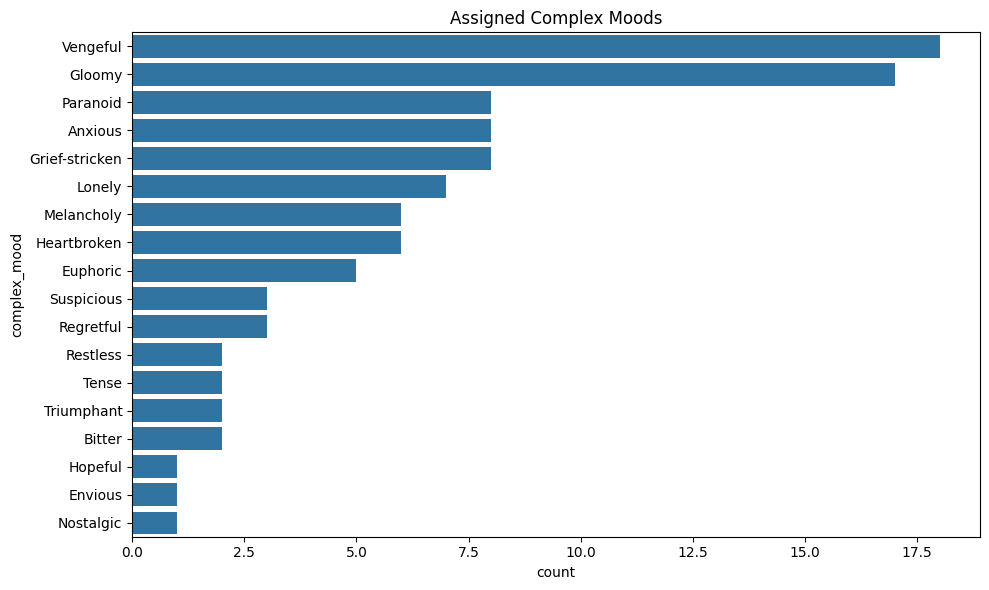

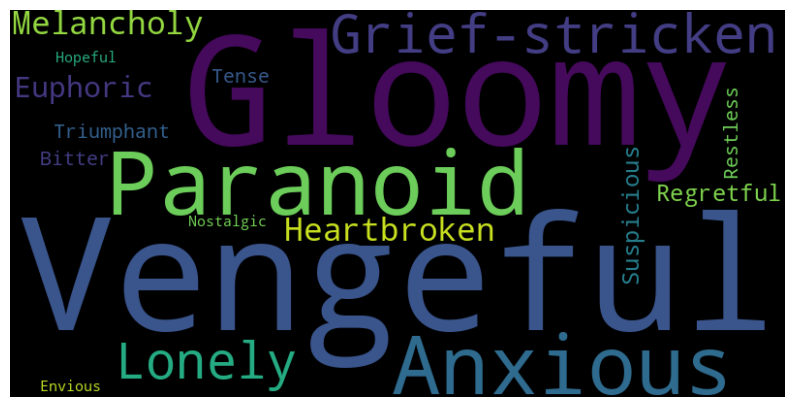

In [ ]:
import pandas as pd
import numpy as np
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# Load data
df = pd.read_csv("dataset_mood_adjusted.csv")

# Load SBERT model (for embeddings already in the DF)
model = SentenceTransformer('all-MiniLM-L6-v2')

# Complex moods & definitions
complex_moods = {
    "Melancholy": "A soft, thoughtful sadness with no clear reason.",
    "Nostalgic": "A warm feeling for the past.",
    "Hopeful": "Positive expectations for the future.",
    "Anxious": "Nervousness and unease about what's coming.",
    "Restless": "Unable to relax due to worry or excitement.",
    "Bitter": "Resentment and disappointment.",
    "Euphoric": "A feeling of intense excitement and happiness.",
    "Heartbroken": "Extreme sadness after emotional loss.",
    "Lonely": "Sadness from being alone or isolated.",
    "Tense": "Mental or emotional strain and anxiety.",
    "Grief-stricken": "Overwhelmed with sorrow after loss.",
    "Vengeful": "Desire to get revenge.",
    "Empowered": "Feeling strong, capable and in control.",
    "Awestruck": "Filled with wonder or amazement.",
    "Ashamed": "Guilt and embarrassment over actions.",
    "Triumphant": "Proud victory over difficulty.",
    "Relieved": "Easing of worry or pain.",
    "Paranoid": "Irrational fear of being harmed or watched.",
    "Envious": "Desiring what someone else has.",
    "Suspicious": "Distrust or doubt of others’ intentions.",
    "Inspired": "Motivated by something beautiful or powerful.",
    "Gloomy": "Dark, depressing and low-spirited.",
    "Regretful": "Wishing things had gone differently.",
    "Disillusioned": "Realizing something isn't as good as expected.",
    "Schadenfreude": "Pleasure in someone else’s misfortune."
}

# 4 basic moods → allowed complex moods
mood_filters = {
    "Happy":    ["Hopeful", "Euphoric", "Triumphant", "Relieved", "Nostalgic"],
    "Sad":      ["Melancholy", "Grief-stricken", "Heartbroken", "Gloomy", "Regretful", "Lonely"],
    "Angry":    ["Vengeful", "Bitter", "Envious"],
    "Fearful":  ["Anxious", "Paranoid", "Suspicious", "Tense", "Restless"]
}

# Precompute SBERT embeddings for complex moods
mood_names = list(complex_moods.keys())
mood_texts = list(complex_moods.values())
mood_embeddings = model.encode(mood_texts, show_progress_bar=True)

def parse_embedding(s: str) -> np.ndarray:
    """Convert a space-separated string '[x y z ...]' into a numpy array."""
    # strip brackets, newlines, then parse
    s_clean = s.strip().lstrip("[").rstrip("]").replace("\n", " ")
    return np.fromstring(s_clean, sep=" ")

def get_best_estimate_for_unknown(basic_mood: str) -> str:
    """Returns a best estimate complex mood when basic mood is 'unknown'."""
    # In case of 'unknown', return the most common complex mood for each basic mood
    if basic_mood == "Happy":
        return "Hopeful"  # Default for happy moods
    elif basic_mood == "Sad":
        return "Melancholy"  # Default for sad moods
    elif basic_mood == "Angry":
        return "Vengeful"  # Default for angry moods
    elif basic_mood == "Fearful":
        return "Anxious"  # Default for fearful moods
    else:
        return "Melancholy"  # Default fallback for unknown

def assign_complex_moods(row):
    # 1) Extract the first basic mood
    basic = row['mood_composite_str'].split(',')[0].strip() if pd.notna(row['mood_composite_str']) else "unknown"

    # Handle case where the basic mood is unknown or missing
    if basic == "unknown":
        basic = get_best_estimate_for_unknown(basic)

    if basic not in mood_filters:
        basic = next((m for m in mood_filters if m in row['mood_composite_str']), "Sad")

    allowed = mood_filters[basic]
    idxs = [mood_names.index(m) for m in allowed]
    allowed_emb = np.vstack([mood_embeddings[i] for i in idxs])

    # 2) Parse the SBERT embedding safely
    vec = parse_embedding(row['sbert_embedding'])
    if vec.size != allowed_emb.shape[1]:
        # fallback: zero vector
        vec = np.zeros(allowed_emb.shape[1])

    # 3) Compute similarities
    sims = cosine_similarity([vec], allowed_emb)[0]

    # 4) Pick top 3
    order = np.argsort(sims)[-3:][::-1]
    top3 = [allowed[i] for i in order]
    top1 = top3[0]
    score = round(sims[order[0]], 4)

    return pd.Series([top1, top3, score, score])

# Apply
df[['complex_mood','top3_complex_moods','complex_mood_score','complex_mood_similarity']] = \
    df.apply(assign_complex_moods, axis=1)

# Save & visualize
df.to_csv("dataset_with_complex_moods_fixed.csv", index=False)

plt.figure(figsize=(10,6))
sns.countplot(y=df['complex_mood'], order=df['complex_mood'].value_counts().index)
plt.title("Assigned Complex Moods")
plt.tight_layout()
plt.show()

wc = WordCloud(width=800, height=400).generate_from_frequencies(df['complex_mood'].value_counts())
plt.figure(figsize=(10,6))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()


In [ ]:
from sklearn.metrics import f1_score

df = pd.read_pickle('dataset_with_ground_truth.pkl')

mood_filters = ['Happy', 'Sad', 'Angry', 'Fearful']

y_pred = []
for index, row in df.iterrows():
    mood_counts = {mood: row['mood_composite'].count(mood) for mood in mood_filters}

    if 'Angry' in row['mood_composite'] and mood_counts['Angry'] > 1:
        predicted_mood = 'Angry'
    elif 'Fearful' in row['mood_composite'] and mood_counts['Fearful'] > 1:
        predicted_mood = 'Fearful'
    else:
        predicted_mood = max(mood_counts, key=mood_counts.get)

    y_pred.append([1 if mood == predicted_mood else 0 for mood in mood_filters])


In [ ]:

f1_scores = f1_score(df['y_true'].tolist(), y_pred, average=None)

for idx, mood in enumerate(mood_filters):
    print(f"F1 score for {mood}: {f1_scores[idx]:.4f}")

f1_macro = f1_score(df['y_true'].tolist(), y_pred, average='macro')
print(f"Macro average F1 score: {f1_macro:.4f}")


F1 score for Happy: 0.6453
F1 score for Sad: 0.9216
F1 score for Angry: 0.7563
F1 score for Fearful: 0.5213
Macro average F1 score: 0.7111
